# Data Analysis of Condition 1, 2 and 3

## 1. Data Preprocess

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval
import scipy.stats as stats
from scipy.stats import pearsonr
import random
import datetime
import scipy
import math

from params import *
from utils import *
from key import *

/opt/anaconda3/envs/web_development/lib/python3.9/site-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
sshtunnel.SSH_TIMEOUT = 5.0
sshtunnel.TUNNEL_TIMEOUT = 5.0

with sshtunnel.SSHTunnelForwarder(
    ('ssh.pythonanywhere.com'),
    ssh_username='Grawi', ssh_password=ssh_password,
    remote_bind_address=('Grawi.mysql.pythonanywhere-services.com', 3306)
) as tunnel:
    print("Successfully connected to Pythonanywhere")
    connection = MySQLdb.connect(
        user='Grawi',
        passwd=db_password,
        host='127.0.0.1', port=tunnel.local_bind_port,
        db='Grawi$Interactive_quiz_database',
    )
    # Do stuff
    print("Successfully connected to database")
    
    start_date = "2024-03-20"
    try:
        cursor = connection.cursor()
        df_1 = pd.read_sql(f"SELECT * FROM condition_1 where submit_time>=\"{start_date}\";", connection)
        df_1["experiment_type"] = "condition_1"
        df_2 = pd.read_sql(f"SELECT * FROM condition_2 where submit_time>=\"{start_date}\";", connection)
        df_2["experiment_type"] = "condition_2"
        df_3 = pd.read_sql(f"SELECT * FROM condition_3 where submit_time>=\"{start_date}\";", connection)
        df_3["experiment_type"] = "condition_3"
        print(f"Data read finished, length: condition 1 length {len(df_1)}, condition 2 length {len(df_2)}, condition 3 length {len(df_3)}")
    
    except Exception as e:
        print("Error:", e)
    
    finally:
        # Close the cursor and connection
        cursor.close()
        connection.close()

df_original = pd.concat([df_1, df_2, df_3])
df_original.tail(5)

2024-04-06 08:37:16,851| ERROR   | Password is required for key /Users/guodawei/.ssh/id_rsa


Successfully connected to Pythonanywhere
Successfully connected to database
Data read finished, length: condition 1 length 0, condition 2 length 438, condition 3 length 0


,participantId,assignmentId,projectId,attention_passed,total_time,identity_choices,ideologies,bot_detected,submit_time,non_ideology_answers,additional_answers,reason,experiment_type,ideology_answers,labels
433,FC1809098A784502A3E33548CD494132,8a3e0d1b-2641-4f97-84b9-0541217b5e75,44f8025d-8022-4a54-a1f9-52b98552cba3,1,519.209,"[[17, 5], [15, 4], [13, 2]]","[-1, null, 1]",66,2024-03-23 23:31:14,"[{""answers"": [0, 1, null], ""time_to_answer"": [...","[[-2, -1, -1]]",,condition_2,"[{""answers"": [1, 0, 1], ""time_to_answer"": [4.1...","[[0], [1], [1]]"
434,FC74ABCA167743B0AC4457D24944F40C,9bb82582-60f4-480a-8c9e-3d15461f2dbe,44f8025d-8022-4a54-a1f9-52b98552cba3,1,659.944,"[[2, 5], [10, 4], [8, 0]]","[-2, null, 2]",33,2024-03-24 00:38:04,"[{""answers"": [null, 1, 0], ""time_to_answer"": [...","[[-2, -2, 2]]",I think everyone is a bot on the internet. I r...,condition_2,"[{""answers"": [1, 1, 0], ""time_to_answer"": [10....","[[0, 4, 8], [0, 8, 4], [2, 8]]"
435,FD2A6686546A4D689BE4A684CD264636,bac1c286-bc09-417c-a605-7585a5a6335b,44f8025d-8022-4a54-a1f9-52b98552cba3,1,457.684,"[[8, 2], [18, 4], [6, 1]]","[-1, null, 2]",33,2024-03-24 00:13:26,"[{""answers"": [0, 1, null], ""time_to_answer"": [...","[[-1.9, 0, 0.8]]",It's hard to get three participants together u...,condition_2,"[{""answers"": [0, 0, 1], ""time_to_answer"": [6.9...","[[0], [1], [2]]"
436,FF4F16DF3E3248B986B79AC83F44764D,6e16d267-d3e6-486f-abd9-131d3e1e6938,44f8025d-8022-4a54-a1f9-52b98552cba3,1,526.359,"[[1, 3], [7, 5], [15, 4]]","[-1, null, 2]",66,2024-03-24 00:07:50,"[{""answers"": [null, 1, 1], ""time_to_answer"": [...","[[-1, -1, 1.6]]",,condition_2,"[{""answers"": [1, 1, 0], ""time_to_answer"": [3.0...","[[1, 5], [1, 6], [2, 5, 7]]"
437,FF8F27F9264E4CE080F8D5079312C55D,48412aae-170a-4b74-aad2-60adbf4b84f9,44f8025d-8022-4a54-a1f9-52b98552cba3,1,462.514,"[[3, 3], [5, 4], [9, 2]]","[-1, null, 2]",65,2024-03-24 00:06:02,"[{""answers"": [null, 0, 0], ""time_to_answer"": [...","[[1.9, 1.8, 1]]",,condition_2,"[{""answers"": [1, 1, 0], ""time_to_answer"": [5.2...","[[4, 6, 8], [2, 4, 6], [3, 4, 6]]"


In [3]:
df = df_original.copy()

### 1.1 Attention check

In [4]:
failed_attention_ids = df.loc[df["attention_passed"] == 0]["participantId"].tolist()
print(f"{len(failed_attention_ids) } participants failed the attention check: {failed_attention_ids}")
df = df.loc[df["attention_passed"] == 1]
columns_to_drop = ['assignmentId', 'projectId', 'attention_passed', 'total_time', 'identity_choices', 'ideologies', 'submit_time', "reason"]
df.drop(columns=columns_to_drop, inplace=True, axis=1)

cols_to_parse = ["additional_answers", "labels"]
for col in cols_to_parse:
    df[col] = df[col].apply(lambda x: literal_eval(x) if pd.notnull(x) else x)
df.set_index("participantId", inplace=True)

# "non_ideology_answers" contains "null" so need to be transformed first
df["non_ideology_answers"] = df["non_ideology_answers"].apply(lambda x: literal_eval(x.replace("null", "None")))

# Data "ideology_answers" of some participants are corrupted, so we need to remove theme
data_error_ids = []
for id, row in df.iterrows():
    if pd.notnull(row["ideology_answers"]):
        try:
            literal_eval(row["ideology_answers"])
        except:
            data_error_ids.append(id)
            df.drop(index=id, inplace=True, axis=0)
print(f"There are {len(data_error_ids)} data errors, ids: {data_error_ids}")
df.drop(columns=["ideology_answers"], inplace=True, axis=1)
df.tail(3)

8 participants failed the attention check: ['08629C209175405BB0C0D31AF6AD8FBC', '4E74BFB9A9064D54BC731E4F67F13B5D', '518CEBE09BB746C58DDCD757BBB596A0', '7DB64DBD8D2840CCB78F873E5D2B55DB', '919B02BFDADA46E886B09BB34DE9F2FB', '9522ECE2CE364A27AE4B05902A494402', 'AB3389B9EC4C4AB69D126444E24011E9', 'BBEDFD83A2B14F5190EA7EAB15FE7557']


There are 0 data errors, ids: []


,bot_detected,non_ideology_answers,additional_answers,experiment_type,labels
participantId,,,,,
FD2A6686546A4D689BE4A684CD264636,33,"[{'answers': [0, 1, None], 'time_to_answer': [...","[[-1.9, 0, 0.8]]",condition_2,"[[0], [1], [2]]"
FF4F16DF3E3248B986B79AC83F44764D,66,"[{'answers': [None, 1, 1], 'time_to_answer': [...","[[-1, -1, 1.6]]",condition_2,"[[1, 5], [1, 6], [2, 5, 7]]"
FF8F27F9264E4CE080F8D5079312C55D,65,"[{'answers': [None, 0, 0], 'time_to_answer': [...","[[1.9, 1.8, 1]]",condition_2,"[[4, 6, 8], [2, 4, 6], [3, 4, 6]]"


### 1.2. Calculate equivalent ideology from labels

Labels mapping:
- **None**: No ideology-related labels are chosen for that participant. These values aren't included in further analysis.
- **0**: Both a label indicating a liberal ideology (*Liberal*, *Somewhat liberal*), and a label indicating a conservative ideology (*Conservative*, *Somwhat conservative*) are chosen.
- **1/2**: If *Conservative* is chosen, then the equivalent value is 2. If only *Somewhat conservative* is chosen, then the value is 1.
- **-1/-2**: Similar as above.

In [5]:
df["labels"] = df["labels"].apply(lambda x: x if type(x) == list else [None, None, None])

def ideology_from_labels(labels):
    if labels is None:
        return None
    
    if set(labels).intersection({0, 1, 2, 3}) == set():
        return None
    
    if set(labels).intersection({0, 1}) != set() and set(labels).intersection({2, 3}) != set():
        return 0
    
    ideology = 0
    if 3 in labels:
        ideology = 1
    if 2 in labels:
        ideology = 2
    if 1 in labels:
        ideology = -1
    if 0 in labels:
        ideology = -2
    return ideology

df["ideology_from_labels"] = df["labels"].apply(lambda labels_list: [ideology_from_labels(labels) for labels in labels_list])
df.tail() 

,bot_detected,non_ideology_answers,additional_answers,experiment_type,labels,ideology_from_labels
participantId,,,,,,
FC1809098A784502A3E33548CD494132,66,"[{'answers': [0, 1, None], 'time_to_answer': [...","[[-2, -1, -1]]",condition_2,"[[0], [1], [1]]","[-2, -1, -1]"
FC74ABCA167743B0AC4457D24944F40C,33,"[{'answers': [None, 1, 0], 'time_to_answer': [...","[[-2, -2, 2]]",condition_2,"[[0, 4, 8], [0, 8, 4], [2, 8]]","[-2, -2, 2]"
FD2A6686546A4D689BE4A684CD264636,33,"[{'answers': [0, 1, None], 'time_to_answer': [...","[[-1.9, 0, 0.8]]",condition_2,"[[0], [1], [2]]","[-2, -1, 2]"
FF4F16DF3E3248B986B79AC83F44764D,66,"[{'answers': [None, 1, 1], 'time_to_answer': [...","[[-1, -1, 1.6]]",condition_2,"[[1, 5], [1, 6], [2, 5, 7]]","[-1, -1, 2]"
FF8F27F9264E4CE080F8D5079312C55D,65,"[{'answers': [None, 0, 0], 'time_to_answer': [...","[[1.9, 1.8, 1]]",condition_2,"[[4, 6, 8], [2, 4, 6], [3, 4, 6]]","[None, 2, 1]"


In [7]:
df["answers"] = df["non_ideology_answers"].apply(lambda answer_wraps: [answer_wrap["answers"][1] for answer_wrap in answer_wraps])
df["bot_answers"] = df["non_ideology_answers"].apply(lambda answer_wraps: [answer_wrap["answers"][answer_wrap["who_answers_first"]] for answer_wrap in answer_wraps])
df.head()

### 1.3. Generate a row for each question

In [32]:
df["additional_answers"] = df["additional_answers"].apply(lambda x: x[0])
df["who_answers_first"] = df["non_ideology_answers"].apply(lambda x: x[0]["who_answers_first"])
df["bot_detected"] = df["bot_detected"].apply(lambda x: [(x // 10) == 3, None, (x % 10) == 3])
df["bot_detected"] = df.apply(lambda row: row["bot_detected"][row["who_answers_first"]], axis=1)
df["same_answer_prob"] = df["non_ideology_answers"].apply(lambda x: sum([answer_wrap["answers"][1] == answer_wrap["answers"][x[0]["who_answers_first"]] for answer_wrap in x]) / len(x))
df["ideology_all_zeros"] = df["additional_answers"].apply(lambda x: x[0] == 0 and x[1] == 0 and x[2] == 0)
df["human_ideology"] = df["additional_answers"].apply(lambda x: x[1])
df["human_ideology_from_labels"] = df["ideology_from_labels"].apply(lambda x: x[1])
df["ideology"] = df["additional_answers"]
df["ideology_distance"] = df.apply(lambda row: abs(row["ideology"][row["who_answers_first"]] - row["ideology"][1]), axis=1)
df = df.loc[:, ["experiment_type", "human_ideology", "human_ideology_from_labels", "bot_detected", "ideology_all_zeros", "ideology_distance", "same_answer_prob"]]
df.tail()

,experiment_type,human_ideology,human_ideology_from_labels,bot_detected,ideology_all_zeros,ideology_distance,same_answer_prob
participantId,,,,,,,
FC1809098A784502A3E33548CD494132,condition_2,-1.0,-1.0,False,False,1.0,0.6
FC74ABCA167743B0AC4457D24944F40C,condition_2,-2.0,-2.0,True,False,4.0,0.6
FD2A6686546A4D689BE4A684CD264636,condition_2,0.0,-1.0,True,False,1.9,0.8
FF4F16DF3E3248B986B79AC83F44764D,condition_2,-1.0,-1.0,False,False,2.6,1.0
FF8F27F9264E4CE080F8D5079312C55D,condition_2,1.8,2.0,False,False,0.8,0.8


## 2. Ideology Distance - Probability of Giving The Same Answer

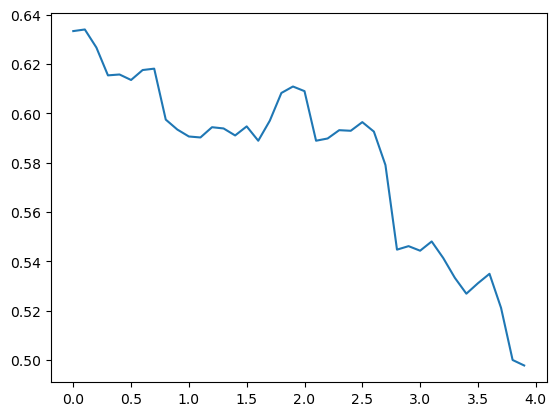

In [33]:
avg, low, high = sliding_average(df["ideology_distance"], df["same_answer_prob"])
plt.plot(avg.index, avg.values)